# 在 LangGraph 中快速上手工具调用

> 官方指南：https://langchain-ai.github.io/langgraph/how-tos/tool-calling/

## 使用 ToolNode 调用工具

[`ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) 是一个 LangChain Runnable 对象，它以图的状态（包含消息列表）作为输入，并输出带有工具调用结果的更新状态。

它设计的目的是与 LangGraph [预建的 ReAct Agent](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/) 良好配合，但也可以与任何 `StateGraph` 配合工作，只要其状态有一个带有适当的 `messages` 键（见 [`MessagesState`](https://github.com/langchain-ai/langgraph/blob/main/libs/langgraph/langgraph/graph/message.py#L99) ）。

In [ ]:
from langchain_core.messages import AIMessage

from langgraph.prebuilt import ToolNode


def get_weather(location: str) -> str:
    """Call to get the current weather."""
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."


def get_coolest_cities() -> str:
    """Get a list of coolest cities"""
    return "nyc, sf"

# Create the tool node with the tools
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

`ToolNode` 在图状态上操作，有一个消息列表。它期望列表中的最后一个消息是一个带有 `tool_calls` 参数的 `AIMessage` 。

首先让我们看看如何手动调用工具节点：

In [ ]:
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "get_weather",
            "args": {"location": "sf"},
            "id": "tool_call_id",
            "type": "tool_call",
        }
    ],
)

# Call the tool node directly with the AIMessage
tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='tool_call_id')]}

In [ ]:
message_with_multiple_tool_calls = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "get_coolest_cities",
            "args": {},
            "id": "tool_call_id_1",
            "type": "tool_call",
        },
        {
            "name": "get_weather",
            "args": {"location": "sf"},
            "id": "tool_call_id_2",
            "type": "tool_call",
        },
    ],
)

tool_node.invoke({"messages": [message_with_multiple_tool_calls]})

{'messages': [ToolMessage(content='nyc, sf', name='get_coolest_cities', tool_call_id='tool_call_id_1'),
  ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='tool_call_id_2')]}

接下来，让我们看看如何在 LangGraph 图中使用 `ToolNode`。

我们构建一个 ReAct Agent 来演示这个案例：Agent 接收一些查询作为输入，然后反复调用工具，直到它有足够的信息来解决查询。我们将使用 `ToolNode` 和 OpenAI 模型以及我们刚刚定义的工具。

In [ ]:
# pip install -qU langchain>=0.2.8
from langchain.chat_models import init_chat_model

# Initialize the LLM with single-line init method
llm = init_chat_model(model="gpt-4o-mini", model_provider="openai", temperature=0)

/root/venv/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `init_chat_model` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [ ]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState

# Define the model with tools
llm_with_tools = llm.bind_tools(tools)

# Define the conditional edge between the nodes
def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

# Define the model node
def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

app = workflow.compile()

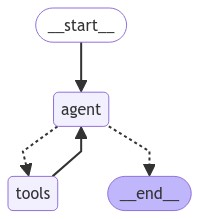

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# example with a single tool call
for chunk in app.stream(
    {"messages": [("human", "what's the weather in sf?")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in sf?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_yv9IQetPJyDFovRU4Va16rFN)
 Call ID: call_yv9IQetPJyDFovRU4Va16rFN
  Args:
    location: San Francisco
================================= Tool Message =================================
Name: get_weather

It's 60 degrees and foggy.
================================== Ai Message ==================================

The weather in San Francisco is currently 60 degrees and foggy.


👆 LangSmith trace: https://smith.langchain.com/public/4b794c2e-034f-41c1-9c9f-ee5460ab8b27/r

In [ ]:
# example with a multiple tool calls in succession
for chunk in app.stream(
    {"messages": [("human", "what's the weather in the coolest cities?")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in the coolest cities?
================================== Ai Message ==================================
Tool Calls:
  get_coolest_cities (call_L5WuMh3O0dZWq9OPtRlsDK31)
 Call ID: call_L5WuMh3O0dZWq9OPtRlsDK31
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

nyc, sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_RvX91QYCiQkWo4wP8wWK0o6B)
 Call ID: call_RvX91QYCiQkWo4wP8wWK0o6B
  Args:
    location: nyc
  get_weather (call_lOtd2QQ4c6Rc3BXQKLS55zZo)
 Call ID: call_lOtd2QQ4c6Rc3BXQKLS55zZo
  Args:
    location: sf
================================= Tool Message =================================
Name: get_weather

It's 60 degrees and foggy.
================================== Ai Message ==================================

The current weather in the coolest cities 

👆 LangSmith trace: https://smith.langchain.com/public/7ffd8a29-29bd-483c-8aa7-66b0a03b0132/r

## 将图的状态传递给工具

有时我们需要将 Agent 的状态传递给我们的工具。这种有状态的工具在工具的输出受已执行的 Agent 步骤影响时很有用（例如，如果您使用一个辅助的 Agent 作为工具，并希望将消息历史传递给这个辅助 Agent），或者当工具的输入需要根据已执行步骤的上下文进行验证时。

当使用 `ToolNode` 时，图状态将自动传递给相关工具和参数。如果我们不想让模型在调用工具时尝试生成某个参数，我们可以使用 `InjectedState` 注解来进行标记，这些参数将不会被模型生成。

在这个例子中，我们将创建一个返回文档的工具，然后创建另一个实际引用这些文档以证明主张的工具。

In [ ]:
# pip install -qU langchain>=0.2.8
from langchain.chat_models import init_chat_model

# Initialize the LLM with single-line init method
llm = init_chat_model(model="gpt-4o-mini", model_provider="openai", temperature=0)

/root/venv/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `init_chat_model` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [ ]:
from typing import List, Tuple
from typing_extensions import Annotated

from langchain_core.documents import Document
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.tools import tool

from langgraph.prebuilt import InjectedState


@tool(parse_docstring=True, response_format="content_and_artifact")
def get_context(question: List[str]) -> Tuple[str, List[Document]]:
    """Get context on the question.

    Args:
        question: The user question
    """
    # return constant dummy output
    docs = [
        Document(
            "FooBar company just raised 1 Billion dollars!",
            metadata={"source": "twitter"},
        ),
        Document(
            "FooBar company is now only hiring AI's", metadata={"source": "twitter"}
        ),
        Document(
            "FooBar company was founded in 2019", metadata={"source": "wikipedia"}
        ),
        Document(
            "FooBar company makes friendly robots", metadata={"source": "wikipedia"}
        ),
    ]
    return "\n\n".join(doc.page_content for doc in docs), docs


@tool(parse_docstring=True, response_format="content_and_artifact")
def cite_context_sources(
    claim: str, state: Annotated[dict, InjectedState]
) -> Tuple[str, List[Document]]:
    """Cite which source a claim was based on.

    Args:
        claim: The claim that was made.
    """
    docs = []
    # We get the potentially cited docs from past ToolMessages in our state.
    for msg in state["messages"]:
        if isinstance(msg, ToolMessage) and msg.name == "get_context":
            docs.extend(msg.artifact)

    class Cite(BaseModel):
        """Return the index(es) of the documents that justify the claim"""

        indexes: List[int]

    structured_model = llm.with_structured_output(Cite)
    system = f"Which of the following documents best justifies the claim:\n\n{claim}"
    context = "\n\n".join(
        f"Document {i}:\n" + doc.page_content for i, doc in enumerate(docs)
    )
    citation = structured_model.invoke([("system", system), ("human", context)])
    cited_docs = [docs[i] for i in citation.indexes]
    sources = ", ".join(doc.metadata["source"] for doc in cited_docs)
    return sources, cited_docs

但是如果我们查看工具调用模式，即传递给模型进行工具调用的内容， `state` 已经被移除：

In [ ]:
cite_context_sources.tool_call_schema.schema()

{'title': 'cite_context_sources',
 'description': 'Cite which source a claim was based on.',
 'type': 'object',
 'properties': {'claim': {'title': 'Claim',
   'description': 'The claim that was made.',
   'type': 'string'}},
 'required': ['claim']}

在此示例中，我们将跟踪的状态将只是一个消息列表。我们希望每个节点只需将消息添加到该列表中。因此，我们将使用一个带有单个键（ `messages` ）的 `TypedDict` ，并对其进行注释，以便始终添加 `messages` 属性。

In [ ]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

让我们定义节点，以及一个决定如何选择条件边的函数。

In [ ]:
from copy import deepcopy

from langchain_core.messages import ToolMessage
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import ToolNode


# Define the function that determines whether to continue or not
def should_continue(state, config):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


tools = [get_context, cite_context_sources]

# Define the function that calls the model
def call_model(state, config):
    messages = state["messages"]
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# ToolNode will automatically take care of injecting state into tools
tool_node = ToolNode(tools)

我们现在可以把它全部放在一起，定义这个图：

In [ ]:
from langgraph.graph import END, START, StateGraph

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

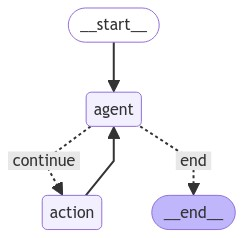

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage("what's the latest news about FooBar")]
for output in app.stream({"messages": messages}):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
        messages.extend(value["messages"])
    print("\n---\n")

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TctQoY2q8mvN3k3pcbWIo1sN', 'function': {'arguments': '{"question":["latest news about FooBar"]}', 'name': 'get_context'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 87, 'total_tokens': 106}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-99bb814c-5851-48eb-8e99-8f52f97f5d24-0', tool_calls=[{'name': 'get_context', 'args': {'question': ['latest news about FooBar']}, 'id': 'call_TctQoY2q8mvN3k3pcbWIo1sN', 'type': 'tool_call'}], usage_metadata={'input_tokens': 87, 'output_tokens': 19, 'total_tokens': 106})]}

---

Output from node 'action':
---
{'messages': [ToolMessage(content="FooBar company just raised 1 Billion dollars!\n\nFooBar company is now only hiring AI's\n\nFooBar company was founded in 2019\n\nFooBar company makes friendly robots", n

👆 LangSmith trace: https://smith.langchain.com/public/1ab99caf-da69-4758-a2d7-b382e2e34125/r

In [ ]:
messages.append(HumanMessage("where did you get this information?"))
for output in app.stream({"messages": messages}):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZuJBgYcMz1dNQDPTTZ2Tw1Dr', 'function': {'arguments': '{"claim": "FooBar company just raised 1 Billion dollars!"}', 'name': 'cite_context_sources'}, 'type': 'function'}, {'id': 'call_fs1kAQQiVvDXehmCLfwApbCA', 'function': {'arguments': '{"claim": "FooBar company is now only hiring AI\'s"}', 'name': 'cite_context_sources'}, 'type': 'function'}, {'id': 'call_sxFtij5bI6RLLqJ2znpjiFuO', 'function': {'arguments': '{"claim": "FooBar company was founded in 2019"}', 'name': 'cite_context_sources'}, 'type': 'function'}, {'id': 'call_br2rJf6dpuF0RJl6DukPuf8c', 'function': {'arguments': '{"claim": "FooBar company makes friendly robots"}', 'name': 'cite_context_sources'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 110, 'prompt_tokens': 213, 'total_tokens': 323}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'finish_reason': 'tool_

👆 LangSmith trace: https://smith.langchain.com/public/d287dacb-f0b7-4fca-b4c7-1dc98a673003/r

## 将图的配置传递给工具

您可能需要传递仅在运行时才知道的值给一个工具。例如，工具逻辑可能需要使用发起请求的用户的 ID。

为了传递运行时信息，我们将使用利用 LangChain Runnable 接口的工具。标准的 Runnable 对象的方法（`invoke`、`batch`、`stream` 等）接受第二个参数，即 `RunnableConfig`。`RunnableConfig` 有几个标准字段，但允许用户使用其他字段来传递运行时信息。

这里，我们将展示如何设置一个简单的 Agent，它可以访问三个工具，用于保存、读取和删除用户喜欢的宠物列表。

In [ ]:
from typing import List

from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig

from langgraph.prebuilt import ToolNode

user_to_pets = {}


@tool(parse_docstring=True)
def update_favorite_pets(
    # NOTE: config arg does not need to be added to docstring, as we don't want it to be included in the function signature attached to the LLM
    pets: List[str],
    config: RunnableConfig,
) -> None:
    """Add the list of favorite pets.

    Args:
        pets: List of favorite pets to set.
    """
    user_id = config.get("configurable", {}).get("user_id")
    user_to_pets[user_id] = pets


@tool
def delete_favorite_pets(config: RunnableConfig) -> None:
    """Delete the list of favorite pets."""
    user_id = config.get("configurable", {}).get("user_id")
    if user_id in user_to_pets:
        del user_to_pets[user_id]


@tool
def list_favorite_pets(config: RunnableConfig) -> None:
    """List favorite pets if any."""
    user_id = config.get("configurable", {}).get("user_id")
    return ", ".join(user_to_pets.get(user_id, []))


tools = [update_favorite_pets, delete_favorite_pets, list_favorite_pets]
tool_node = ToolNode(tools)

In [ ]:
# pip install -qU langchain>=0.2.8
from langchain.chat_models import init_chat_model

# Initialize the LLM with single-line init method
llm = init_chat_model(model="gpt-4o-mini", model_provider="openai", temperature=0)
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState


def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

app = workflow.compile()

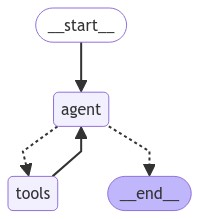

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
from langchain_core.messages import HumanMessage

user_to_pets.clear()  # Clear the state

print(f"User information prior to run: {user_to_pets}")

inputs = {"messages": [HumanMessage(content="my favorite pets are cats and dogs")]}
for output in app.stream(inputs, {"configurable": {"user_id": "123"}}):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

print(f"User information after the run: {user_to_pets}")

User information prior to run: {}
Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZBiiGO0DvVWCKRPL7USZQ8By', 'function': {'arguments': '{"pets":["cats","dogs"]}', 'name': 'update_favorite_pets'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 97, 'total_tokens': 117}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e2d16b33-1a6d-491a-a723-147e303889fc-0', tool_calls=[{'name': 'update_favorite_pets', 'args': {'pets': ['cats', 'dogs']}, 'id': 'call_ZBiiGO0DvVWCKRPL7USZQ8By', 'type': 'tool_call'}], usage_metadata={'input_tokens': 97, 'output_tokens': 20, 'total_tokens': 117})]}

---

Output from node 'tools':
---
{'messages': [ToolMessage(content='null', name='update_favorite_pets', tool_call_id='call_ZBiiGO0DvVWCKRPL7USZQ8By')]}

---

Output from node 'agent':
---
{'messages': [AIMessage(content

👆 LangSmith trace: https://smith.langchain.com/public/93fc15e4-646d-438b-b025-58f372da32ba/r

In [ ]:
print(f"User information prior to run: {user_to_pets}")


inputs = {
    "messages": [
        HumanMessage(content="please forget what i told you about my favorite animals")
    ]
}
for output in app.stream(inputs, {"configurable": {"user_id": "123"}}):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")


print(f"User information prior to run: {user_to_pets}")

User information prior to run: {'123': ['cats', 'dogs']}
Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SVuaJAPGUaGXYatW4AdPgiyS', 'function': {'arguments': '{}', 'name': 'delete_favorite_pets'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 100, 'total_tokens': 113}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f04b1ec3-b084-487b-bf51-506bd202a525-0', tool_calls=[{'name': 'delete_favorite_pets', 'args': {}, 'id': 'call_SVuaJAPGUaGXYatW4AdPgiyS', 'type': 'tool_call'}], usage_metadata={'input_tokens': 100, 'output_tokens': 13, 'total_tokens': 113})]}

---

Output from node 'tools':
---
{'messages': [ToolMessage(content='null', name='delete_favorite_pets', tool_call_id='call_SVuaJAPGUaGXYatW4AdPgiyS')]}

---

Output from node 'agent':
---
{'messages': [AIMessage(content="I've forgotten your

👆 LangSmith trace: https://smith.langchain.com/public/b0318bbc-f750-44dc-8baa-7f407bce57bf/r

## 处理工具调用错误

LLM 在调用工具方面并不完美。模型可能会尝试调用一个不存在的工具，或者无法返回与请求的架构匹配的参数。像保持架构简单、减少一次性传递的工具数量、以及拥有良好的名称和描述等策略可以帮助减轻这种风险，但并非万无一失。

例如，下面的工具需要输入一个特定长度的元素列表 —— 这对一个小模型来说很棘手！我们还将故意避免将 `topic` 复数化，以欺骗模型认为它应该传递一个字符串：

In [ ]:
# pip install -qU langchain>=0.2.8
from langchain.chat_models import init_chat_model

# Initialize the LLM with single-line init method
model = init_chat_model(model="gpt-3.5-turbo-0125", model_provider="openai", temperature=0)

In [ ]:
from typing import Literal

from langchain_core.output_parsers import StrOutputParser
from langchain.pydantic_v1 import BaseModel, conlist
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


class HaikuRequest(BaseModel):
    topic: conlist(str, min_items=3, max_items=3)


def master_haiku_generator(request: HaikuRequest) -> str:
    """Generates a haiku based on the provided topics."""
    chain = model | StrOutputParser()
    topics = ", ".join(request.topic)
    haiku = chain.invoke(f"Write a haiku about {topics}")
    return haiku


tool_node = ToolNode([master_haiku_generator])

model_with_tools = model.bind_tools([master_haiku_generator])


def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

app = workflow.compile()

response = app.invoke(
    {"messages": [("human", "Write me an incredible haiku about water.")]},
    {"recursion_limit": 10},
)

for message in response["messages"]:
    string_representation = f"{message.type.upper()}: {message.content}\n"
    print(string_representation)

HUMAN: Write me an incredible haiku about water.

AI: 

TOOL: Error: ValidationError(model='master_haiku_generatorSchema', errors=[{'loc': ('request', 'topic'), 'msg': 'ensure this value has at least 3 items', 'type': 'value_error.list.min_items', 'ctx': {'limit_value': 3}}])
 Please fix your mistakes.

AI: I need at least 3 topics to generate a haiku. Could you provide two more topics related to water?



👆 LangSmith trace: https://smith.langchain.com/public/f2bb9b64-7a6a-4ce7-9c2f-9bf3c0ab4252/r

可能更好的策略是剪掉失败的尝试以减少干扰，然后退回到一个更高级的模型。以下是一个例子。我们还使用自定义节点来调用我们的工具，而不是使用预构建的 `ToolNode` ：

In [ ]:
# pip install -qU langchain>=0.2.8
from langchain.chat_models import init_chat_model

# Initialize the LLM with single-line init method
model = init_chat_model(model="gpt-3.5-turbo-0125", model_provider="openai", temperature=0)
better_model = init_chat_model(model="gpt-4o-mini", model_provider="openai", temperature=0)

In [ ]:
import json

from langchain_core.tools import tool
from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.messages.modifier import RemoveMessage


class HaikuRequest(BaseModel):
    topic: conlist(str, min_items=3, max_items=3)

@tool
def master_haiku_generator(request: HaikuRequest) -> str:
    """Generates a haiku based on the provided topics."""
    chain = model | StrOutputParser()
    topics = ", ".join(request.topic)
    haiku = chain.invoke(f"Write a haiku about {topics}")
    return haiku


def call_tool(state: MessagesState):
    tools_by_name = {master_haiku_generator.name: master_haiku_generator}
    messages = state["messages"]
    last_message = messages[-1]
    output_messages = []
    for tool_call in last_message.tool_calls:
        try:
            tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            output_messages.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        except Exception as e:
            # Return the error if the tool call fails
            output_messages.append(
                ToolMessage(
                    content="",
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                    additional_kwargs={"error": e},
                )
            )
    return {"messages": output_messages}


model_with_tools = model.bind_tools([master_haiku_generator])
better_model_with_tools = better_model.bind_tools([master_haiku_generator])


def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def should_fallback(
    state: MessagesState,
) -> Literal["agent", "remove_failed_tool_call_attempt"]:
    messages = state["messages"]
    failed_tool_messages = [
        msg
        for msg in messages
        if isinstance(msg, ToolMessage)
        and msg.additional_kwargs.get("error") is not None
    ]
    if failed_tool_messages:
        return "remove_failed_tool_call_attempt"
    return "agent"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


def remove_failed_tool_call_attempt(state: MessagesState):
    messages = state["messages"]
    # Remove all messages from the most recent
    # instance of AIMessage onwards.
    last_ai_message_index = next(
        i
        for i, msg in reversed(list(enumerate(messages)))
        if isinstance(msg, AIMessage)
    )
    messages_to_remove = messages[last_ai_message_index:]
    return {"messages": [RemoveMessage(id=m.id) for m in messages_to_remove]}


# Fallback to a better model if a tool call fails
def call_fallback_model(state: MessagesState):
    messages = state["messages"]
    response = better_model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", call_tool)
workflow.add_node("remove_failed_tool_call_attempt", remove_failed_tool_call_attempt)
workflow.add_node("fallback_agent", call_fallback_model)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_conditional_edges("tools", should_fallback)
workflow.add_edge("remove_failed_tool_call_attempt", "fallback_agent")
workflow.add_edge("fallback_agent", "tools")

app = workflow.compile()

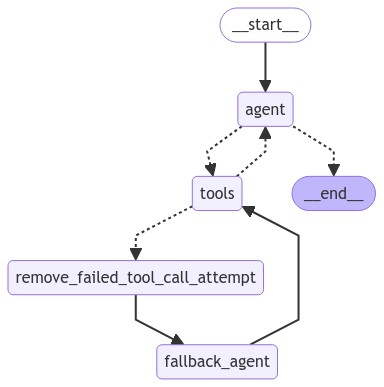

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

`tools` 节点现在将在工具调用失败时返回包含 `error` 字段的 `ToolMessage`。如果发生这种情况，它将转到另一个节点，该节点会删除失败的工具消息，并使用更好的模型重试工具调用生成。

为了强调删除步骤，让我们 `stream` 模型的响应，以便我们可以看到每个执行的节点：

In [ ]:
stream = app.stream(
    {"messages": [("human", "Write me an incredible haiku about water.")]},
    {"recursion_limit": 10},
)

for chunk in stream:
    print(chunk)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ekN5HFxwieF2vry7fnsPZjH4', 'function': {'arguments': '{"request":{"topic":["water"]}}', 'name': 'master_haiku_generator'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 78, 'total_tokens': 98}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-798a6cc8-6937-484e-8642-9a6d6e5ce999-0', tool_calls=[{'name': 'master_haiku_generator', 'args': {'request': {'topic': ['water']}}, 'id': 'call_ekN5HFxwieF2vry7fnsPZjH4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 78, 'output_tokens': 20, 'total_tokens': 98})]}}
{'tools': {'messages': [ToolMessage(content='', additional_kwargs={'error': ValidationError(model='master_haiku_generatorSchema', errors=[{'loc': ('request', 'topic'), 'msg': 'ensure this value has at least 3 items', 'type': 'value_error.list.min_items', 'ctx': {

👆 LangSmith trace: https://smith.langchain.com/public/41985e65-7666-4380-bc21-af2a6722727a/r

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e6124301-0a3c-4c43-a70b-884a597351fa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>